#  Прогнозирование заказов такси

***Описание проекта:*** 

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

***Описание данных:***

- `num_orders` — число заказов.

***План работы над проектом:***

1. Подготовка данных
2. Анализ данных
3. Обучение моделей
4. Тестирование модели
5. Общий вывод

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    TimeSeriesSplit)

from sklearn.metrics import (
    mean_squared_error,
    make_scorer)

from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(rc={'figure.figsize': (10,7)})

In [2]:
def start(df):
        df.info()
        print('\n',df.describe())
        display(df.sample(5))
        print('Количество пропусков в таблице:', df.isna().sum().sum(), '\n')
        print(df.isna().sum(), '\n')
        print('Количество дубликатов в таблице:',  df.duplicated().sum())
        df.hist(figsize=(10, 6));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB

          num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


,datetime,num_orders
17270,2018-06-28 22:20:00,8
275,2018-03-02 21:50:00,16
16827,2018-06-25 20:30:00,7
593,2018-03-05 02:50:00,2
11538,2018-05-20 03:00:00,21


Количество пропусков в таблице: 0 

datetime      0
num_orders    0
dtype: int64 

Количество дубликатов в таблице: 0


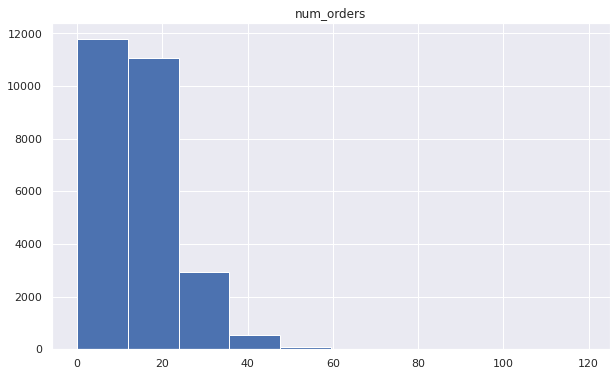

In [3]:
data = pd.read_csv('taxi.csv')
start(data)

В таблице у нас `2` стоблца. Пропуски и дубликаты отсутствуют. По графику количества заказов мы заметили, что основные значения эт диапазон `от 0 до 20`. Продолжим подготовку данных для нашего исследования. Проведём ресемплирование по `1` часу.

Для этого первый столбец в датой и временем переведём в соответствующий тип данных и обозначим его как индекс таблицы.

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime').sort_index(ascending=True)

print(data.index.is_monotonic)

True


Отсортировав индекс мы убедили, что данные расположены в хронологическом порядке. Непосредственно сделаем ресемплирование.

In [5]:
data = data.resample('1H').sum()
data.sample(3)

,num_orders
datetime,
2018-06-06 09:00:00,83
2018-05-10 01:00:00,74
2018-07-18 17:00:00,129


**Вывод:** В начале работы мы познакомились с данными. И провели предобработку, прежде чем обучать модели. Что именно было сделано:
- в исходных данных у нас `2` стоблца; 
- пропуски и дубликаты отсутствуют; 
- по графику количества заказов мы заметили, что основные значения в диапазоне `от 0 до 20`;
- первый столбец (`datetime`) с датой и временем перевели в соответствующий тип данных и обозначили его как индекс таблицы;
- отсортировали индекс в хронологическом порядке и сделали ресемплирование данных по `1` часу.

## Анализ данных

Для начала мы посмотрим на данные со стороны наличия трендов и сезонности.

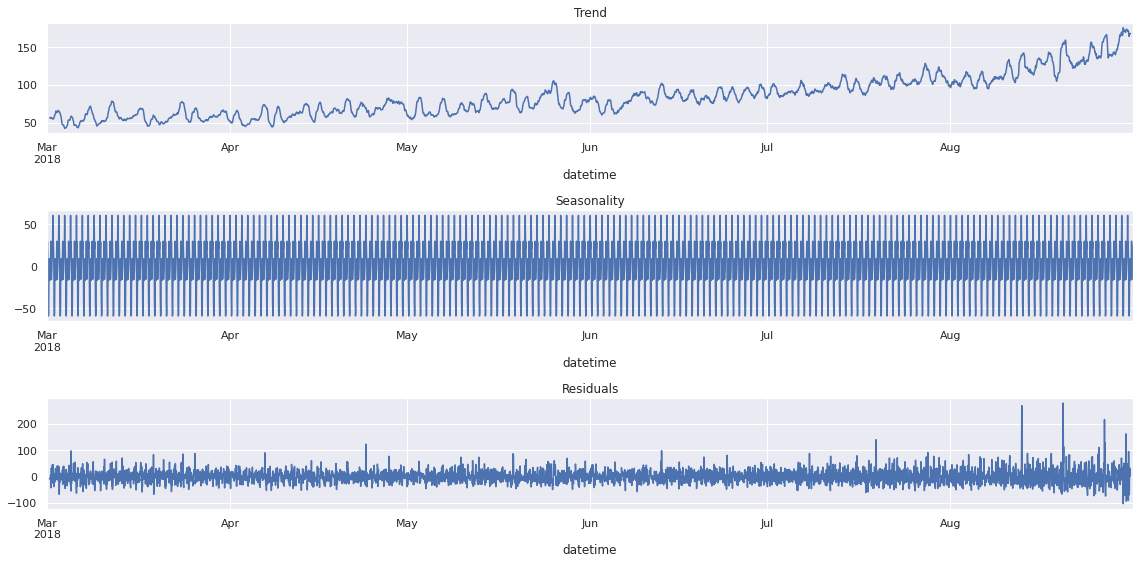

In [6]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видим, что данные у нас на 2018 год и с марта по сентябрь. Поэтому по годовой сезонности мы никакие выводы не сможем сделать, однако видно некий тренд, который говорит, что с июля по сентябрь закзов такси в аэропорты больше.

Посмотрим сезонность на более коротком интервале. Это будет 20 дней апреля.

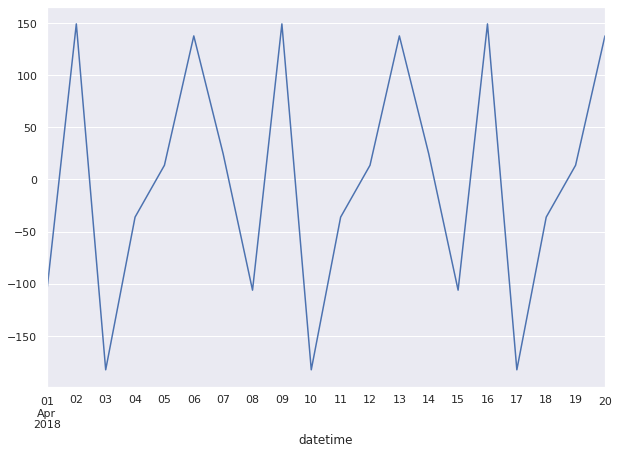

In [7]:
data_season = data.resample('1D').sum()
decomposed = seasonal_decompose(data_season)

decomposed.seasonal['2018-04-01':'2018-04-20'].plot();

Мы видим, что в данных присутствует сезонность в масштабах недели, а именно, что наименьший поток заказов приходится на вторник недели, а пики заказов заметны в пятницу и понедельник.

Далее мы создадим ещё один столбец в котором выделим часы работы. На графике отобразим сгруппированые значения заказов по каждому часу. Посмотрим распределение в течение суток.

In [8]:
data['hours'] = data.index.hour

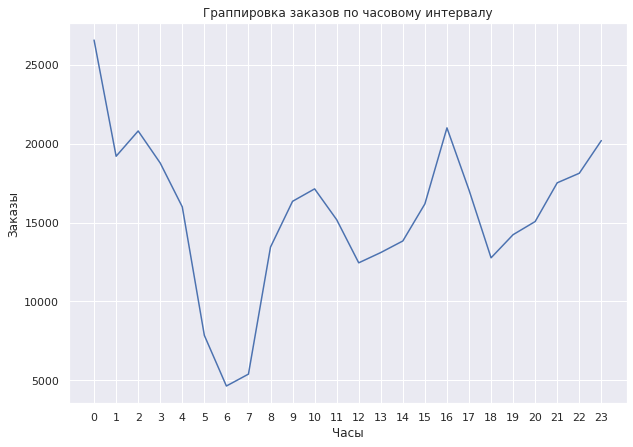

In [9]:
data.groupby('hours')['num_orders'].sum().plot(kind='line');

# добавление заголовков и меток осей
plt.title('Граппировка заказов по часовому интервалу')
plt.xlabel('Часы')
plt.ylabel('Заказы')

# установка меток на оси x
plt.xticks(range(0, 24))

plt.show()

По графику видно, что меньше всего заказов выпадает на `6 утра`, а пиковая нагрузка на `полночь`.

In [10]:
# удалим вспомогатльный столбец из таблицы
data = data.drop('hours', axis=1)

**Вывод:** Для начала мы посмотрели на данные со стороны наличия трендов и сезонности и обраружили, что данные у нас на `2018 год и с марта по сентябрь`. Поэтому по годовой сезонности мы никакие выводы не смогли сделать, однако увидели некий тренд, который говорит, что `с июля по сентябрь закзов такси в аэропорты больше`. Так же мы посмотрели сезонность в масштабах недели. Взяли для этого срез данных - первые `20` дней апреля. Увидели, что наименьший поток заказов приходится на вторник недели, а пики заказов заметны в пятницу и понедельник. Далее мы создали ещё один столбец в котором выделили часы работы в течение суток. Построили график и увидели, что меньше всего заказов выпадает на `6` утра, а пиковая нагрузка на `полночь`.

## Обучение моделей

Для начала обучения добавим в таблицу новые признаки. Используем функцию, которая у нас есть в наличие.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [12]:
make_features(data, 24, 48)

# удалим строки где есть пропуски. это нюанс временных рядов
data = data.dropna()
data.sample(3)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-04-21 21:00:00,57,21,5,67.0,70.0,45.0,61.0,81.0,81.0,67.0,...,43.0,80.0,70.0,110.0,119.0,167.0,96.0,150.0,114.0,72.2500
2018-07-24 21:00:00,113,24,1,82.0,81.0,118.0,120.0,112.0,114.0,116.0,...,66.0,104.0,144.0,101.0,149.0,165.0,79.0,104.0,119.0,108.2500
2018-08-10 10:00:00,153,10,4,81.0,67.0,62.0,44.0,47.0,122.0,80.0,...,90.0,178.0,150.0,80.0,65.0,79.0,123.0,85.0,149.0,107.5625


Хорошо. Сделаем разбивку на обучающую и тестовую выборки. Размер тестовой выборки у нас будет `10%`.

In [13]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']

In [14]:
features_train, features_test, target_train, target_test  = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=12345)

print(features_train.shape[0])
print(features_test.shape[0])

3931
437


Будем работать с `3` моделями. `LinearRegression, CatBoost и RandomForestRegressor`. Для поиска лучших гиперпараметров будем использовать `GridSearchCV`.

Начнём с первой. `LinearRegression`.

In [15]:
model = LinearRegression()

# используем TimeSeriesSplit для кросс-валидации временных рядов
cv = TimeSeriesSplit(n_splits=5)

# зададим параметры
param_grid = {}

def RMSE (y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(RMSE, greater_is_better=False)

grid = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1, scoring=rmse_scorer)
grid.fit(features_train, target_train)

RMSE_lr_train = grid.best_score_ * -1

print('Параметры лучшей модели:', grid.best_params_)
print('RMSE лучшей модели:', RMSE_lr_train)

Параметры лучшей модели: {}
RMSE лучшей модели: 27.440705735462803


Вторая модель `CatBoost`.

In [16]:
model = CatBoostRegressor(verbose=False, random_state=12345)

# используем TimeSeriesSplit для кросс-валидации временных рядов
cv = TimeSeriesSplit(n_splits=5)

# зададим параметры
param_grid = {'depth': range (1, 15, 2),
              'learning_rate': np.arange (0.1, 0.5),
             }

def RMSE (y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(RMSE, greater_is_better=False)

grid = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1, scoring=rmse_scorer)
grid.fit(features_train, target_train)

RMSE_cbr_train = grid.best_score_ * -1

print('Параметры лучшей модели:', grid.best_params_)
print('RMSE лучшей модели:', RMSE_cbr_train)

Параметры лучшей модели: {'depth': 7, 'learning_rate': 0.1}
RMSE лучшей модели: 24.965429496761068


Третья модель `RandomForestRegressor`.

In [17]:
model = RandomForestRegressor(random_state=12345)

# используем TimeSeriesSplit для кросс-валидации временных рядов
cv = TimeSeriesSplit(n_splits=5)

# зададим параметры
param_grid = {'n_estimators': range (100, 301, 100),
              'max_depth': range (1, 15, 2),
              #'min_samples_leaf': range (1, 8),
              #'min_samples_split': range (2, 10, 2)
             }

def RMSE (y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(RMSE, greater_is_better=False)

grid = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1, scoring=rmse_scorer)
grid.fit(features_train, target_train)

RMSE_rfr_train = grid.best_score_ * -1

print('Параметры лучшей модели:', grid.best_params_)
print('RMSE лучшей модели:', RMSE_rfr_train)

Параметры лучшей модели: {'max_depth': 13, 'n_estimators': 300}
RMSE лучшей модели: 25.79016311698706


Составим таблицы для наглядности результатов.

In [18]:
tabledata = [["LinearRegression", RMSE_lr_train],
             ["RandomForestRegressor", RMSE_rfr_train],
             ["CatBoostRegressor", RMSE_cbr_train]]
df= pd.DataFrame(tabledata, columns=["Model", "RMSE_train"])
df

,Model,RMSE_train
0,LinearRegression,27.440706
1,RandomForestRegressor,25.790163
2,CatBoostRegressor,24.965429


**Вывод:** Перед началом обучения моделей мы добавили в таблицу новые признаки и разбили полученный датасет на обучающую и тестовую выборки. Соотношение `90/10`. Обучали `3` модели. `LinearRegression, CatBoost и RandomForestRegressor`. Для поиска лучших гиперпараметров использовали `GridSearchCV`. Как итог - лучшая модель CatBoostRegressor с RMSE 24.96. Параметры лучшей модели: {'depth': 7, 'learning_rate': 0.1}

## Тестирование модели

Теперь имея в распоряжении лучшие гиперпараметры протестируем модель на тестовой выборке.

In [19]:
model_cbr = CatBoostRegressor(depth=7, learning_rate=0.1, verbose=False, random_state=12345)
model_cbr.fit(features_train, target_train)
predicted = model_cbr.predict(features_test)

RMSE_cbr_test = mean_squared_error(target_test, predicted, squared=False)
print('RMSE', RMSE_cbr_test)

RMSE 41.02160598991008


**Вывод:** Результат модели на тестовой выборке `RMSE 41`. 

## Общий вывод

В начале работы мы познакомились с данными. И провели предобработку, прежде чем обучать модели. Что именно было сделано:
- в исходных данных у нас `2` стоблца; 
- пропуски и дубликаты отсутствуют; 
- по графику количества заказов мы заметили, что основные значения в диапазоне `от 0 до 20`;
- первый столбец (`datetime`) с датой и временем перевели в соответствующий тип данных и обозначили его как индекс таблицы;
- отсортировали индекс в хронологическом порядке и сделали ресемплирование данных по `1` часу.

При анализе данных мы посмотрели со стороны наличия трендов и сезонности и обраружили, что данные у нас на `2018 год и с марта по сентябрь`. Поэтому по годовой сезонности мы никакие выводы не смогли сделать, однако увидели некий тренд, который говорит, что `с июля по сентябрь закзов такси в аэропорты больше`. Так же мы посмотрели сезонность в масштабах недели. Взяли для этого срез данных - первые `20` дней апреля. Увидели, что наименьший поток заказов приходится на вторник недели, а пики заказов заметны в пятницу и понедельник. Далее мы создали ещё один столбец в котором выделили часы работы в течение суток. Построили график и увидели, что меньше всего заказов выпадает на `6` утра, а пиковая нагрузка на `полночь`.

Перед началом обучения моделей мы добавили в таблицу новые признаки и разбили полученный датасет на обучающую и тестовую выборки. Соотношение `90/10`. Обучали `3` модели. `LinearRegression, CatBoost и RandomForestRegressor`. Для поиска лучших гиперпараметров использовали `GridSearchCV`. Как итог - лучшая модель `CatBoostRegressor с RMSE 24.96`. Параметры лучшей модели: `{'depth': 7, 'learning_rate': 0.1}`

In [20]:
tabledata = [["LinearRegression", RMSE_lr_train],
             ["RandomForestRegressor", RMSE_rfr_train],
             ["CatBoostRegressor", RMSE_cbr_train]]
df= pd.DataFrame(tabledata, columns=["Model", "RMSE_train"])
df

,Model,RMSE_train
0,LinearRegression,27.440706
1,RandomForestRegressor,25.790163
2,CatBoostRegressor,24.965429


На тестовой выборке резльтат модели `CatBoostRegressor - RMSE 41`.